- Image scale normalization
- Image format normalization (.jpg, .png) ✅
- overlay ✅
- blurring ✅
- pixelate ✅
- sharpness
- shifting ✅
- merging?

In [43]:
# import dependencies

import matplotlib.image as mimg
import matplotlib.pyplot as plt
import numpy as np
import math
import random

In [44]:
# Image initialization

def _get_image(path):
    img = mimg.imread(path)

    if path.endswith('.jpg') or path.endswith('.tif') or path.endswith('.jpeg'):
        return img / 255 # numpy is awesome

    return img


img1 = _get_image('Input Images/Spiral.jpg')
img2 = _get_image('Input Images/Oogway_forest.jpg')
img3 = _get_image('Input Images/F.png')
img4 = _get_image('Input Images/Pacman Background.tif')
img5 = _get_image('Input Images/Bokeh1.png')
img6 = _get_image('Input Images/Bokeh2.png')

In [45]:
# dependency functions

# overlay dependency
def _avg_pixel_weighted(channel_val1, weight1, channel_val2, weight2) -> int:
    adjusted_weight_total = weight1 + weight2
    return ( (channel_val1 * weight1 + channel_val2 * weight2)/adjusted_weight_total)

def _find_stop_pixelate(height,  width, grid_size, start_pixel) -> list:
    x_dim, y_dim = start_pixel
    padding = grid_size//2
    _stop = (padding + 1) if grid_size & 1 else padding

    e_h = height % grid_size if (height - x_dim) <= padding else None # second axis
    e_w = width % grid_size if (width - y_dim) <= padding else None # first axis

    empty_stop_height = -padding + e_h if e_h is not None else _stop
    empty_stop_width = -padding + e_w if e_w is not None else _stop      # refactor _stop to above

    return [empty_stop_height, empty_stop_width]

# refactor
def _find_stop_blur(height, width, grid_size, start_pixel) -> list:
    x_dim, y_dim = start_pixel
    padding = grid_size//2
    _stop = (padding + 1) if grid_size & 1 else padding

    if x_dim < height or y_dim < width:
        e_h = height - x_dim if (height - x_dim) <= padding and (x_dim < height) else _stop
        e_w = width - y_dim if (width - y_dim) <= padding and (y_dim < width) else _stop

    if x_dim >= height or y_dim >= width:
        e_h = height - (x_dim - padding) if (height - x_dim) <= padding and (x_dim >= height) else _stop
        e_w = width - (y_dim - padding) if (width - y_dim) <= padding and (y_dim >= width) else _stop

    return [e_h, e_w]

# blur, pixelate dependency
def _avg_color_in_grid(img, grid_size, start_pixel, img_type):

    x_dim, y_dim = start_pixel
    padding = grid_size//2 # no. of pixels on either side of central pixel

    _stop = (padding + 1) if grid_size & 1 else padding  # (less on right side if even)

    r_total, g_total, b_total = 0, 0, 0

    # height, width, _ = img.shape

    # if x_dim < height - _stop and y_dim < width - _stop:
    try:
        r_total, g_total, b_total = 0, 0, 0

        # default grid_size^2 for all pixels not on top or left edge
        total_pixels = grid_size**2 if x_dim > padding and y_dim > padding else 0

        for _i in range(-padding, _stop):
            for _j in range(-padding, _stop):

                if (x_dim + _i >= 0 ) and (y_dim + _j >= 0):

                    r_total += img.item((x_dim + _i, y_dim + _j, 0))
                    g_total += img.item((x_dim + _i, y_dim + _j, 1))
                    b_total += img.item((x_dim + _i, y_dim + _j, 2))

                    # increment by one if pixels on top or left edge
                    total_pixels += 1 and total_pixels != grid_size**2

    # else:
    except IndexError:
        r_total, g_total, b_total = 0, 0, 0
        height, width, _ = img.shape

        if img_type == "BLUR":
            empty_stop_height, empty_stop_width = _find_stop_blur(height, width, grid_size, start_pixel)
        elif img_type == "PIXELATE":
            empty_stop_height, empty_stop_width = _find_stop_pixelate(height, width, grid_size, start_pixel)

        total_pixels = 0
        for _i in range(-padding, empty_stop_height):
            for _j in range(-padding, empty_stop_width):

                r_total += img.item((x_dim + _i, y_dim + _j, 0))
                g_total += img.item((x_dim + _i, y_dim + _j, 1))
                b_total += img.item((x_dim + _i, y_dim + _j, 2))

                total_pixels+=1

    return np.array((r_total, g_total, b_total)) / total_pixels

def _impose_fine(img, fine_img, threshold):
    height, width, _ = img.shape
    new_img_arr = np.zeros(shape=(height, width, 3))

    for i in range(height):
        for j in range(width):
            for k in range(3):
                color_channel = fine_img.item((i, j, k))

                new_img_arr[i, j, k] = color_channel if color_channel > threshold else img.item((i, j, k))

    return new_img_arr

In [46]:
# OVERLAY

def overlay(img1, img1_weight, img2, img2_weight):

    max_x_size = max(img1.shape[0], img2.shape[0])
    max_y_size = max(img1.shape[1], img2.shape[1])

    new_img_arr = np.zeros(shape=(max_x_size, max_y_size, 3))

    for i in range(max_x_size):
        for j in range(max_y_size):
            for k in range(3):

                new_img_arr[i, j, k] = _avg_pixel_weighted(img1.item((i, j, k)), img1_weight, img2.item((i, j, k)), img2_weight)  # 4 sec

    return new_img_arr


In [47]:
# PIXELATE

def pixelate(img, pixelate_amount):

    height, width, _ = img.shape

    padding = pixelate_amount//2

    new_img_arr = np.zeros(shape=(height, width, 3))

    for i in range(padding, height + padding, pixelate_amount):
        for j in range(padding, width + padding, pixelate_amount):
            color = _avg_color_in_grid(img, pixelate_amount, (i, j), "PIXELATE")

            try:
                _stop = (padding + 1) if pixelate_amount & 1 else padding

                for _i in range(-padding, _stop):
                    for _j in range(-padding, _stop):

                        new_img_arr[i + _i, j + _j] = color

            except(IndexError):
                empty_stop_height, empty_stop_width = _find_stop_pixelate(height, width, pixelate_amount, (i, j))

                for _i in range(-padding, empty_stop_height):
                    for _j in range(-padding, empty_stop_width):

                        new_img_arr[i + _i, j + _j] = color

    return new_img_arr


In [48]:
# BLUR

def blur(img, blur_size = 3):
    # blur_size = int(input("Blur size: "))
    # 2 - 18.5s
    # 3 - 24.6s
    # 5 - ~47s
    # 7 - 1m 57.2s
    # 10 - 2m 37.5s

    height, width, _ = img.shape

    new_img_arr = np.zeros(shape=(height, width, 3))

    for i in range(height):
        for j in range(width):

            new_img_arr[i, j] = _avg_color_in_grid(img, blur_size, (i, j), "BLUR")

    return new_img_arr


In [49]:
# SHIFT

def shift(img, operation, start_val_increment=1.6, shift_x=10, shift_y=10, start_offset=0):
    # operation = int(input("what operation should be performed? (0:linear, 1:sin, 2:cos, 3:tan, 4:random)  "))
    multiplicant = 0

    start_val = 0

    height, width, _ = img.shape

    new_img_arr = np.zeros(shape=(height, width, 3))

    for i in range(height):
        for j in range(width):
            for k in range(3):
                if operation == 4:
                    multiplicant = random.random() * 2 - 1

                new_img_arr[i, j, k] = img.item((
                    ((int(multiplicant * shift_x)) + i + start_offset) %
                    height,
                    ((int(multiplicant * shift_y)) + j + start_offset) %
                    width, k))

        multiplicant = start_val if operation == 0 else math.sin(start_val) if operation == 1 else math.cos(start_val) if operation == 2 else math.tan(start_val) if operation == 3 else 0

        start_val+=start_val_increment # for sin or cos, min and max shift is 0 and 1.5707 (π/2)

    return new_img_arr


In [50]:
# blurred_img = blur(img6, blur_size=20)

In [51]:
# SHARPEN

def sharpen(img, threshold):

    fine_img = abs(img - blurred_img)

    # return _impose_fine(img, fine_img, threshold)
    return fine_img
    # return(img + 0)

In [52]:
# plt.imsave("Output Images/Overlay/Overlay 3-1.jpg", overlay(img1, img2))
# plt.imsave("Output Images/Blur/Blur 5.png", blur(img2, blur_size=5))
# plt.imsave("Output Images/Sharpen/Sharp 20.png", sharpen(img6, 50))
# plt.imsave("Output Images/Sharpen/Sharp 15overlayed.png", _impose_fine(img6, _get_image('Output Images/Sharpen/Sharp 15.png'), 10))
# plt.imshow( sharpen(img2, 250))
# plt.imsave("Output Images/Blur/Blur 10.png", blur(img1, blur_size=10))
# plt.imsave("Output Images/Blur/Blur 7.png", blur(img2, blur_size=7))
# plt.imsave("Output Images/Blur/Blur 2.png", blur(img2, blur_size=2))
# plt.imsave("Output Images/Pixelate/Pixelate 20.png", pixelate(img1, 20))
# plt.imsave("Output Images/Distort/Random.png", shift(img2, 4))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


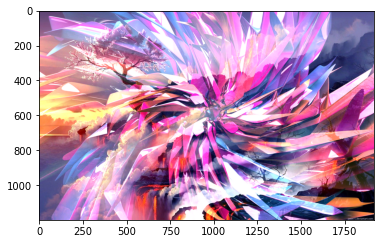

In [53]:
plt.imshow(img2 + img1)